In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from collections import Counter

filt = lambda x: '_' in x
get_letter = lambda x: x.split('.')[0]
#·for·i·in·range(10):
letters = list(filter(filt,glob('*.npy')))
letters= ['l0_ya.npy', 'l1_yu.npy', 'l2_oi.npy', 'l3_yoi.npy', 'l4_yai.npy', 'l5_p.npy',
          'l6_m.npy', 'l7_t.npy', 'l8_r.npy', 'l9_b.npy',
          'letsbuy.npy', 'letsgo.npy', 'letsride.npy', 'kick.npy','getout.npy']
letters = letters[:10]
ls = list(map(np.load, letters)) # letters[:10], letters[10:]
d = dict(zip(list(map(get_letter,letters)),ls))
d

{'l0_ya': array([[0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 0., 0.]]),
 'l1_yu': array([[1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0.]]),
 'l2_oi': array([[0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 1.]]),
 'l3_yoi': array([[0., 1., 0., 1., 0.],
        [1., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [1., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0.]]),
 'l4_yai': array([[0., 1., 0., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 0., 1., 0.]]),
 'l5_p': array([[1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [1., 1., 1., 1., 1.]]),
 'l6_m': array([[1., 1., 1., 1., 

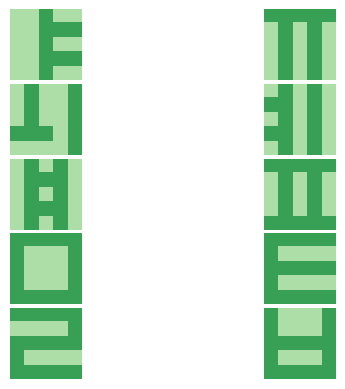

In [2]:
letters = [ 'l0_ya.npy', 'l1_yu.npy', 'l2_oi.npy', 'l3_yoi.npy', 'l4_yai.npy',
            'l5_p.npy', 'l6_m.npy', 'l7_t.npy', 'l8_r.npy', 'l9_b.npy']
fig, ax = plt.subplots(len(letters)//2,2)
ax = [a for ae in ax for a in ae]
for i, lett in enumerate(letters):
    ax[i].imshow(np.load(lett), cmap=plt.cm.Greens, clim=[-1,2])
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.05,hspace=0.05)

0 0
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4


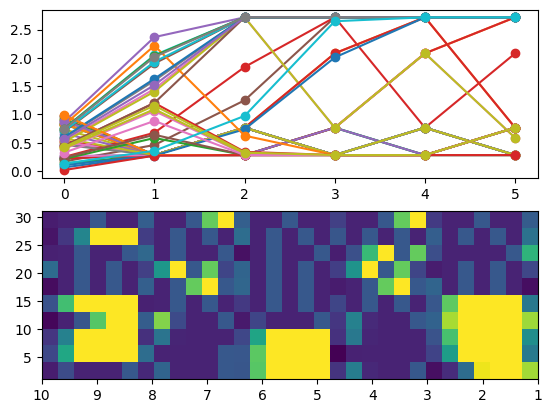

<Figure size 640x480 with 0 Axes>

In [3]:
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(2, 1)
t = np.arange(6)
plt.plot(t, np.cumsum(1 / 150 * np.exp(-t)), '-o')

inp = np.array([1., 0., 1., 0., 1.])

def output_row(initial_state, input_signal):
    """
    This function emulates the behavior of a memristor PoC.
    Insert here a more detailed model or integrate a differential equation
    for better behavior.
    Ideally the experimental data should be here.
    Parameters
    ----------
    initial_state : conductance value before any pulse.
    input_signal : signal of the applied pulses.
    Returns
    -------
    a : the output of the conductance. this has to be extracted of the device.
    """
    a = [initial_state]
    for i in range(5):
        if input_signal[i] > 0:
            a.append(np.clip(a[i], 0.1, 1) * np.exp(1))
        else:
            a.append(np.clip(a[i], 1, 10) * (3 - np.exp(1)))
    return np.array(a).flatten()  # 确保 output 为一维数组

matrix = np.zeros((10, 31))
nr = 0
for nl, lett in enumerate(d.keys()):
    print(nl, nr)
    for nr, row in enumerate(d[lett]):
        initial_state = np.random.random(1)
        output = output_row(initial_state, row)

        # 确保 output 与 matrix 的目标切片形状一致
        if output.size >= 6:
            ax[0].plot(output[:6] + np.random.random(1) * 1e-4, '-o')
            matrix[nl, nr * 6:(nr + 1) * 6] = output[:6]
        else:
            print(f"Warning: output size {output.size} is too small.")

matrix[:, 30] = 2.5 * np.random.random((10,))

plt.figure()
ax[1].imshow(matrix, extent=[10, 1, 1, 31], aspect='auto')
plt.show()


In [4]:
"""
one hot encoding, softmax function activation and training procedure
"""
def one_hot(y, c):
    """
    # y--> label/ground truth.
    # c--> Number of classes.
    """
    # A zero matrix of size (m, c)
    y_hot = np.zeros((len(y), c))
    # Putting 1 for column where the label is,
    # Using multidimensional indexing.
    y_hot[np.arange(len(y)), y] = 1
    return y_hot

one_hot([5,2,3], 10)

def softmax(z):
    # z--> linear part.
    # subtracting the max of z for numerical stability.
    exp = np.exp(z - np.max(z))
    # Calculating softmax for all example letters.
    for i in range(len(z)):
        exp[i] /= np.sum(exp[i])
    return exp

# fit(X,np.arange(10),0.1,10,100)
def fit(X, y, lr, c, epochs):
    """
    # X --> Input.
    # y --> true/target value.
    # lr --> Learning rate.
    # c --> Number of classes.
    # epochs --> Number of iterations.
    """
    # m-> number of training examples
    # n-> number of features
    m, n = X.shape
    # Initializing weights and bias randomly.
    w = np.random.random((n, c))
    b = np.random.random(c)
    # Empty list to store losses.
    losses = []
    # np.save('initial_w.npy',w)
    # Training loop.
    for epoch in range(epochs):
        # Calculating hypothesis/prediction.
        z = X@w + b
        y_hat = softmax(z)
        # One-hot encoding y.
        y_hot = one_hot(y, c)
        # Calculating the gradient of loss w.r.t w and b.
        w_grad = (1/m)*np.dot(X.T, (y_hat - y_hot))
        b_grad = (1/m)*np.sum(y_hat - y_hot)
        # Updating the parameters.
        w = w - lr*w_grad
        b = b - lr*b_grad
        # np.save('w' + str(epoch) + '.npy',w)
        # Calculating loss and appending it in the list.
        loss = -np.mean(np.log(y_hat[np.arange(len(y)), y]))
        losses.append(loss)
        # Printing out the loss at every 100th iteration.
        if epoch%1==0:
            print('Epoch {epoch}==> Loss = {loss}'.format(epoch=epoch, loss=loss))
    return w, b, losses

Epoch 0==> Loss = 3.1698278789479577
Epoch 1==> Loss = 2.5234608601429356
Epoch 2==> Loss = 2.2643691173185583
Epoch 3==> Loss = 2.0649912865401694
Epoch 4==> Loss = 1.9062585710616786
Epoch 5==> Loss = 1.7775962378201715
Epoch 6==> Loss = 1.6705734416375884
Epoch 7==> Loss = 1.578452661504748
Epoch 8==> Loss = 1.4965761212144078
Epoch 9==> Loss = 1.4222774453163192
Epoch 10==> Loss = 1.3541852760984594
Epoch 11==> Loss = 1.2915411035849282
Epoch 12==> Loss = 1.233821897336466
Epoch 13==> Loss = 1.1805894479697083
Epoch 14==> Loss = 1.1314430172175824
Epoch 15==> Loss = 1.0860086447030475
Epoch 16==> Loss = 1.0439389461173554
Epoch 17==> Loss = 1.0049146326636378
Epoch 18==> Loss = 0.968645247761968
Epoch 19==> Loss = 0.9348687110300202
Epoch 20==> Loss = 0.9033498991187825
Epoch 21==> Loss = 0.8738786258725556
Epoch 22==> Loss = 0.846267343319614
Epoch 23==> Loss = 0.8203487958915565
Epoch 24==> Loss = 0.7959737728965974
Epoch 25==> Loss = 0.7730090362153448
Epoch 26==> Loss = 0.75133

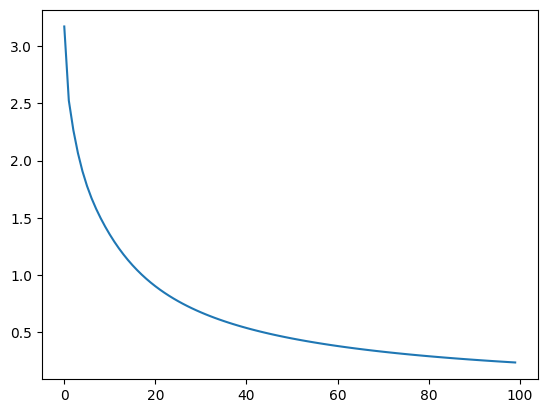

In [6]:
""" 10 examples for the training, each example has 6*5 features, or 30 virtual reservoir nod
"""
X = np.zeros((10,30))
for i, letter in enumerate(d.keys()):
    initial_state = np.random.random(1)
    output = []
    for row in d[letter]:
        output.append(output_row(initial_state,row))
    X[i,:] = np.concatenate(output)  # 去掉[:, 0]，直接赋值

    
w, b, losses = fit(X,np.arange(10),0.1,10,100)

plt.figure()
plt.plot(losses)

prediction of the corresponding letter 0 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


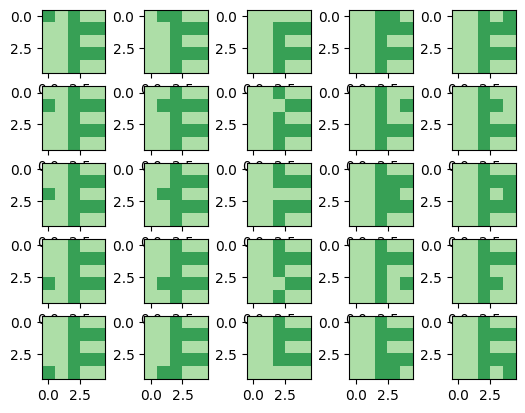

In [9]:
"""
here I add noise in each position of the 25 positions of the matrix
"""
cc = ['l0_ya.npy', 'l1_yu.npy', 'l2_oi.npy', 'l3_yoi.npy',
      'l4_yai.npy', 'l5_p.npy', 'l6_m.npy', 'l7_t.npy',
      'l8_r.npy', 'l9_b.npy']
# fig345, ax345 = plt.subplots(5,5)
# test_letter = d[cc[0].split('.')[0]]
# for i in range(5):
# for j in range(5):
# test_letter = d[cc[0].split('.')[0]].copy()
# test_letter[i,j] = 1 if not test_letter[i,j] else 0
# ax345[i,j].imshow(np.array(test_letter.copy()), cmap='jet')
# for i in range(5):
# for j in range(5):
# print (5*i+j)
""" 10 examples for the training, each example has 6*5 features, or 30 virtual reservoir nod
"""
X = np.zeros((25,30))
num_letter = 0# between 0 and 9
# test_letter = d[cc[0].split('.')[0]]
fig345, ax345 = plt.subplots(5,5)

for i in range(5):
    for j in range(5):
        test_letter = d[cc[num_letter].split('.')[0]].copy()
        test_letter[i,j] = 1 if not test_letter[i,j] else 0
        initial_state = np.random.random(1)
        output = []
        case_letter = np.array(test_letter.copy())
        ax345[i,j].imshow(np.array(case_letter),cmap=plt.cm.Greens, clim=[-1,2])
        for row in case_letter:
            output.append(output_row(initial_state,row))
        X[5*i+j,:] = np.concatenate(output)

def predict(X, w, b):
    """ X --> Input.
    w --> weights.
    b --> bias."""
    # Predicting
    z = X@w + b
    y_hat = softmax(z)
    # print (y_hat.shape)
    # Returning the class with highest probability.
    return np.argmax(y_hat, axis=1)
    # return y_hat

# for i in range(30)
print ('prediction of the corresponding letter', num_letter, ':', predict(X, w, b))

prediction of the corresponding letter 0 : [0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
prediction of the corresponding letter 0 : [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
prediction of the corresponding letter 0 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3]
prediction of the corresponding letter 0 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3]
prediction of the corresponding letter 0 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction of the corresponding letter 1 : [1 1 1 5 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction of the corresponding letter 1 : [1 1 1 5 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction of the corresponding letter 1 : [1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
prediction of the corresponding letter 1 : [1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
prediction of the corresponding letter 1 : [1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1]
prediction of the corresponding letter 2 : [2 2 2 

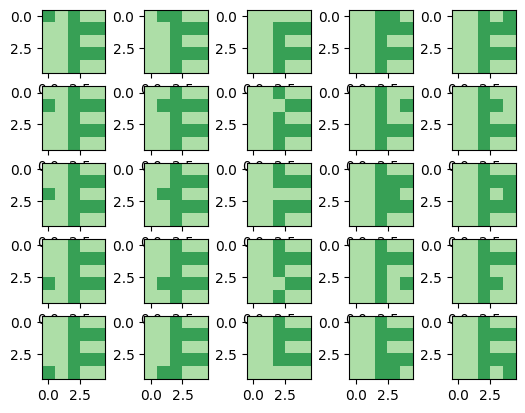

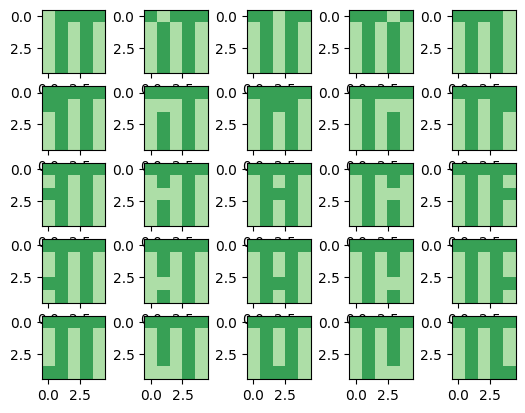

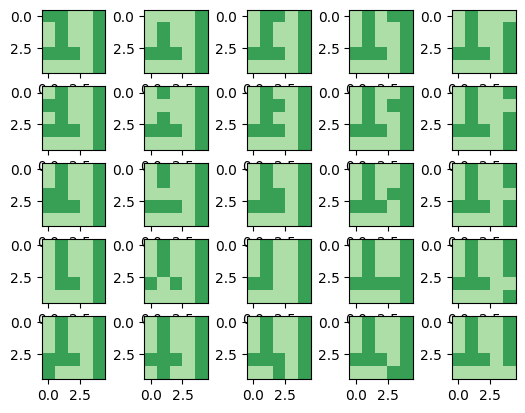

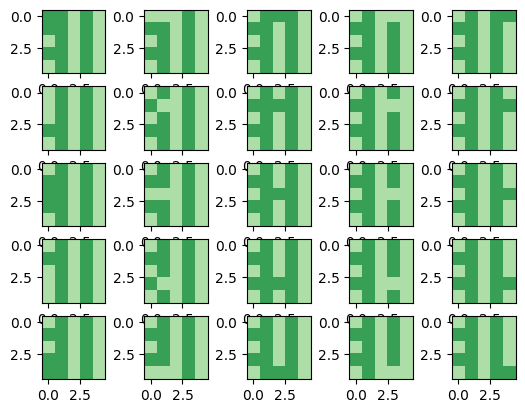

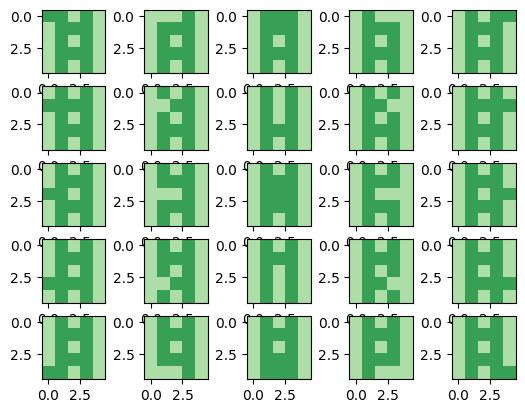

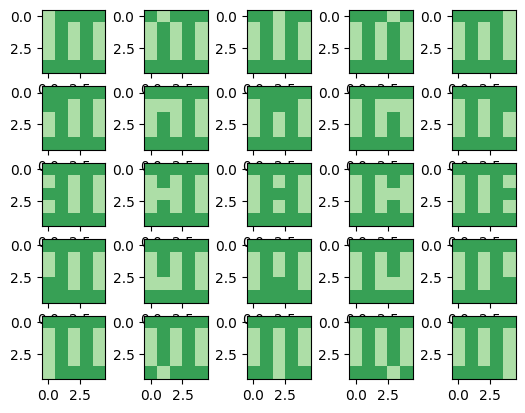

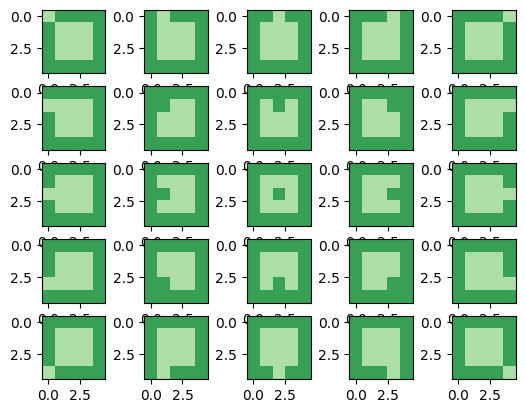

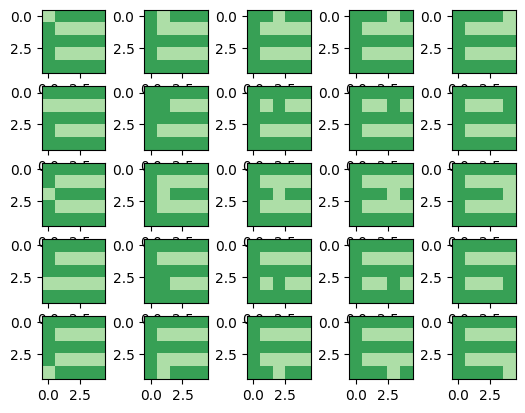

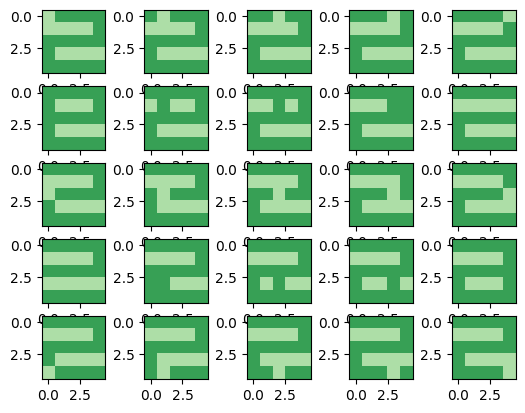

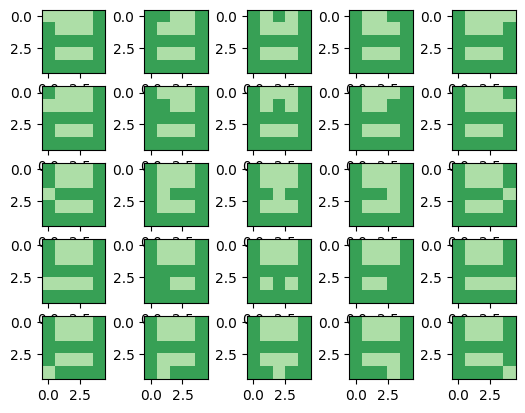

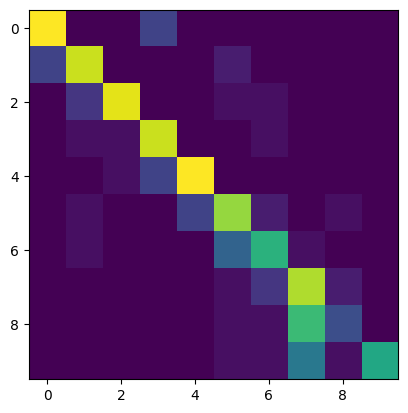

In [10]:
def predict(X, w, b):
    """ X --> Input.
    w --> weights.
    b --> bias."""
    # Predicting
    z = X@w + b
    y_hat = softmax(z)
    # print (y_hat.shape)
    # Returning the class with highest probability.
    return np.argmax(y_hat, axis=1)

""" test the 10 cases for making the confusion matrix
"""
X = np.zeros((25,30))
confusion_matrix = np.zeros((10,10))

for num_letter in range(10):# between 0 and 9
    # test_letter = d[cc[0].split('.')[0]]
    fig345, ax345 = plt.subplots(5,5)
    for i in range(5):
        for j in range(5):
            test_letter = d[cc[num_letter].split('.')[0]].copy()
            test_letter[i,j] = 1 if not test_letter[i,j] else 0
            initial_state = np.random.random(1)
            output = []
            case_letter = np.array(test_letter.copy())
            ax345[i,j].imshow(np.array(case_letter),cmap=plt.cm.Greens, clim=[-1,2])
            for row in case_letter:
                output.append(output_row(initial_state,row))
            X[5*i+j,:] = np.concatenate(output)
        predictions = predict(X, w, b)
        print ('prediction of the corresponding letter', num_letter, ':', predictions)
        for n_lett, prob in Counter(predictions).items():
            confusion_matrix[num_letter, n_lett] = prob/25*100.
            
plt.figure()
plt.imshow(confusion_matrix)